### Import Necessary Dependencies

In [165]:
#Import libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist

import string

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils.multiclass import unique_labels


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras import optimizers
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

import gensim
from gensim.models import Word2Vec

np.random.seed(0)

%matplotlib inline
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /Users/Filip/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Filip/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Read and Load the Dataset

In [3]:
# Upload datasets
df = pd.read_csv('tweet_product_company.csv', encoding = 'unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
len(df.emotion_in_tweet_is_directed_at.unique())

10

In [6]:
df.columns = ['tweet_text', 'product', 'label']
df.head()

,tweet_text,product,label
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [7]:
for column in df.columns[1:]:
    print('Column: ', column)
    print('Unique values count:', len(df[column].unique()))
    print('Values: ', df[column].unique())
    print('----------------')

Column:  product
Unique values count: 10
Values:  ['iPhone' 'iPad or iPhone App' 'iPad' 'Google' nan 'Android' 'Apple'
 'Android App' 'Other Google product or service'
 'Other Apple product or service']
----------------
Column:  label
Unique values count: 4
Values:  ['Negative emotion' 'Positive emotion'
 'No emotion toward brand or product' "I can't tell"]
----------------


Combine labels "I can't tell" and 'No emotion toward brand or product' to one category "Neutral emotion"

In [8]:
df['label'][df['label'] == "I can't tell"] = 'Neutral emotion'
df['label'][df['label'] == 'No emotion toward brand or product'] = 'Neutral emotion'

In [9]:
for column in df.columns[1:]:
    print('Column: ', column)
    print('Unique values count:', len(df[column].unique()))
    print('Values: ', df[column].unique())
    print('----------------')

Column:  product
Unique values count: 10
Values:  ['iPhone' 'iPad or iPhone App' 'iPad' 'Google' nan 'Android' 'Apple'
 'Android App' 'Other Google product or service'
 'Other Apple product or service']
----------------
Column:  label
Unique values count: 3
Values:  ['Negative emotion' 'Positive emotion' 'Neutral emotion']
----------------


In [10]:
# Create summary of Nan and unique values counts and data types
X_info = pd.DataFrame(df.isna().sum(), columns=['NaN count'])

unique_val = []
types_val = []
zero_val = []

for column in df.columns:
    unique = df[column].nunique()
    types = str(df[column].dtype)
    zeros = len(df[df[column]==0])
    
    unique_val.append(unique)
    types_val.append(types)
    zero_val.append(zeros)

X_info['Zero values count'] = zero_val
X_info['Unique_val count'] = unique_val
X_info['Data type'] = types_val

X_info.sort_values(by=['NaN count', 'Zero values count'], ascending=False)

,NaN count,Zero values count,Unique_val count,Data type
product,5802,0,9,object
tweet_text,1,0,9065,object
label,0,0,3,object


### Data Visualization of Target Variables

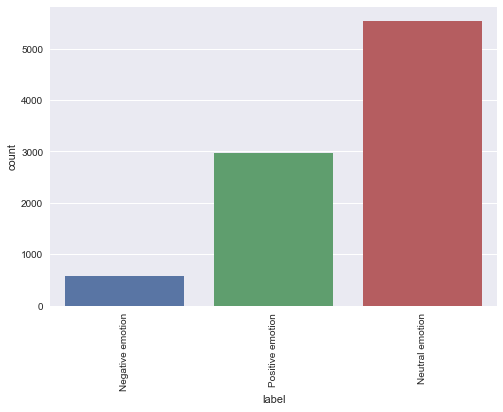

In [168]:
ax = sns.countplot(x='label', data=df)
ax.tick_params(axis='x', rotation=90)

In [12]:
df['label'].value_counts(normalize=True)

Neutral emotion     0.609810
Positive emotion    0.327505
Negative emotion    0.062686
Name: label, dtype: float64

In [190]:
#Class weight to address class imbalance
class_weights = df['label'].value_counts(normalize=True).to_dict()
print(class_weights)

{'Neutral emotion': 0.6097668279806423, 'Positive emotion': 0.327540695116586, 'Negative emotion': 0.06269247690277167}


In [13]:
df.groupby(by=['product']).count()

,tweet_text,label
product,,
Android,78,78
Android App,81,81
Apple,661,661
Google,430,430
Other Apple product or service,35,35
Other Google product or service,293,293
iPad,946,946
iPad or iPhone App,470,470
iPhone,297,297


### Cleaning and Preprocessing Data

In [14]:
df.dropna(subset=['tweet_text'], axis='rows', inplace=True)

#### Break apart the data and the labels, and then inspect the class names

In [180]:
data = df.drop(columns=['label','product'])
target = df.drop(columns=['tweet_text','product'])

In [181]:
c = target.label.astype('category')
label_names = dict(enumerate(c.cat.categories))
print (label_names)

{0: 'Negative emotion', 1: 'Neutral emotion', 2: 'Positive emotion'}


In [183]:
#change type of column
target['label'] = pd.Categorical(target['label'])

In [184]:
target['label'] = target['label'].cat.codes

In [192]:
#Class weight dictionary after converiting to categorical to address class imbalance
class_weights = target['label'].value_counts(normalize=True).to_dict()
print(class_weights)

{1: 0.6097668279806423, 2: 0.327540695116586, 0: 0.06269247690277167}


In [24]:
# #### Getting a list of all of the english stopwords, and concatenating 
# them with a list of all the punctuation.
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``']

In [25]:
def process_tweet(tweet):
    tokens = nltk.word_tokenize(tweet)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed

#### Check tweet lenghts distrubution and max value

In [29]:
# Convert training data into tensors to feed into neural net
# create tokenizer
t = Tokenizer()
t.fit_on_texts(data['tweet_text'])

In [30]:
# Find number of unique words in our tweets
vocab_size = len(t.word_index) + 1

In [31]:
# integer encode everything
sequences = t.texts_to_sequences(data['tweet_text'])

In [32]:
# Find longest tweet in sequences
def max_tweet():
    for i in range(1, len(sequences)):
        max_length = len(sequences[0])
        if len(sequences[i]) > max_length:
            max_length = len(sequences[i])
    return max_length

In [33]:
max_tweet_len = max_tweet()
max_tweet_len

24

In [34]:
#Truncate and pad input sequences to be all the same lenght vectors
padded_data = pad_sequences(sequences, maxlen=max_tweet_len)

In [35]:
padded_data

array([[5869,   23,   51, ..., 3955,    6,    1],
       [   0,    0, 5870, ..., 3956,    6,    1],
       [   0,    0,    0, ...,  208,    6,    1],
       ...,
       [   0,    0,  110, ...,   16,    1, 2452],
       [   0,  157,  687, ...,  143, 2546,    1],
       [   0,    0,    0, ...,    6,    1,    4]], dtype=int32)

In [155]:
X_train, X_test, y_train, y_test = train_test_split(padded_data, target, test_size = 0.2, random_state = 0)

In [156]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [157]:
# Size of train and test datasets
print('X_train size:', X_train.shape)
print('y_train size:', y_train.shape)
print('X_test size:', X_test.shape)
print('y_test size:', y_test.shape)

X_train size: (7273, 24)
y_train size: (7273, 3)
X_test size: (1819, 24)
y_test size: (1819, 3)


### Pre-trained word embedding

In [ ]:
# load the whole embedding into memory
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
# 50 dimensional version (embedding dimension)
embeddings_index = dict()
f = open('glove/glove.twitter.27B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

In [59]:
import pickle

# with open('embeddings_index.pickle', 'wb') as handle:
#     pickle.dump(embeddings_index, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('embeddings_index.pickle', 'rb') as handle:
    embeddings_index = pickle.load(handle)

In [41]:
###### Because we're using GloVE, need to create a word embedding/word context matrix
# Create a matrix of weights for words in the training set
# One embedding for each word in the training set

# Get all unique words in our training set: Tokenizer index
# Find the corresponding weight vector in GloVe embedding

# Define size of embedding matrix: number of unique words x embedding dim (100)
embedding_matrix = np.zeros((vocab_size, 50))

# fill in matrix
for word, i in t.word_index.items():  # dictionary
    embedding_vector = embeddings_index.get(word) # gets embedded vector of word from GloVe
    if embedding_vector is not None:
        # add to matrix
        embedding_matrix[i] = embedding_vector # each row of matrix

In [42]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.32527   ,  1.20930004,  0.15962   , ..., -1.10020006,
        -0.91891003,  0.48025   ],
       [ 1.21739995,  1.01839995, -0.60869998, ..., -0.88479   ,
         0.58089   , -0.09434   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [43]:
# input is vocab_size, output is 50
# weights from embedding matrix, set trainable = False
tweet_num = max_tweet_len
embedding_layer = Embedding(input_dim=vocab_size, output_dim=50, weights=[embedding_matrix],
                           input_length = tweet_num, trainable=False)

### Build Neural Net

In [44]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import BatchNormalization

In [48]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

#### Model 1: Simple LSTM Model with regularization, increase dimensionality

In [193]:
lstm_mod1 = Sequential()
lstm_mod1.add(embedding_layer)
lstm_mod1.add(LSTM(256, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
lstm_mod1.add(Dense(3, activation='softmax'))
lstm_mod1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_mod1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 24, 50)            507400    
_________________________________________________________________
lstm_13 (LSTM)               (None, 256)               314368    
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 771       
Total params: 822,539
Trainable params: 315,139
Non-trainable params: 507,400
_________________________________________________________________


In [196]:
history_1 = lstm_mod1.fit(X_train, y_train,
                    validation_split = 0.2, class_weight=class_weights,
                    epochs=100, batch_size=256)

Train on 5818 samples, validate on 1455 samples
Epoch 1/100
5818/5818 [==============================] - 13s 2ms/step - loss: 0.3052 - acc: 0.6040 - val_loss: 0.2773 - val_acc: 0.6034
Epoch 2/100
5818/5818 [==============================] - 9s 2ms/step - loss: 0.2732 - acc: 0.6121 - val_loss: 0.2718 - val_acc: 0.6034
Epoch 3/100
5818/5818 [==============================] - 9s 2ms/step - loss: 0.2717 - acc: 0.6129 - val_loss: 0.2737 - val_acc: 0.6048
Epoch 4/100
5818/5818 [==============================] - 8s 1ms/step - loss: 0.2700 - acc: 0.6121 - val_loss: 0.2728 - val_acc: 0.6034
Epoch 5/100
5818/5818 [==============================] - 9s 2ms/step - loss: 0.2671 - acc: 0.6157 - val_loss: 0.2672 - val_acc: 0.6055
Epoch 6/100
5818/5818 [==============================] - 12s 2ms/step - loss: 0.2627 - acc: 0.6195 - val_loss: 0.2610 - val_acc: 0.6062
Epoch 7/100
5818/5818 [==============================] - 13s 2ms/step - loss: 0.2600 - acc: 0.6251 - val_loss: 0.2591 - val_acc: 0.6110
Epoc

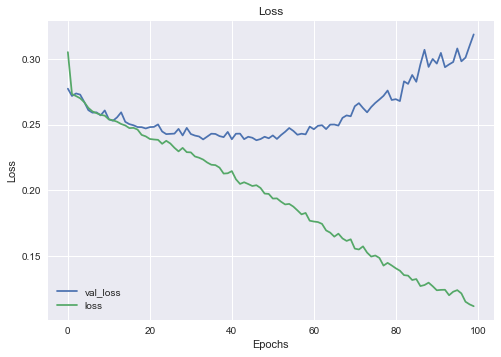

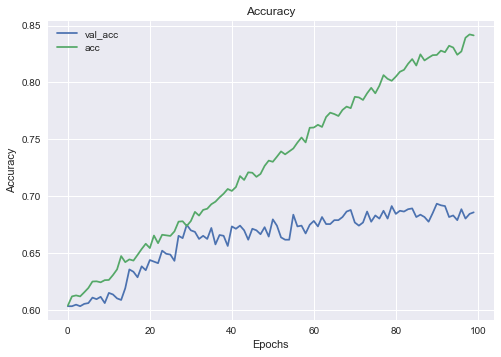

In [197]:
visualize_training_results(history_1)

In [198]:
# Find train and test accuracy
loss, accuracy = lstm_mod1.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod1.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#0.90/0.66

Training Accuracy: 0.8525
Testing Accuracy:  0.6734


### Model 2: LSTM with regularization, reduce dimensionality

In [207]:
lstm_mod2 = Sequential()
lstm_mod2.add(embedding_layer)
lstm_mod2.add(Dropout(0.3))
lstm_mod2.add(LSTM(100, 
               dropout = 0.3, 
               recurrent_dropout = 0.5))
lstm_mod2.add(Dense(3, activation='softmax'))
lstm_mod2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_mod2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 24, 50)            507400    
_________________________________________________________________
dropout_10 (Dropout)         (None, 24, 50)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 303       
Total params: 568,103
Trainable params: 60,703
Non-trainable params: 507,400
_________________________________________________________________


In [208]:
# Import EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=15), 
                  ModelCheckpoint(filepath='best_model_lstm.h5', monitor='val_loss', save_best_only=True)]

In [209]:
history_2 = lstm_mod2.fit(X_train, y_train,
                    validation_split = 0.2, 
                    class_weight=class_weights,
                    callbacks=early_stopping,
                    epochs=200, batch_size=500)

Train on 5818 samples, validate on 1455 samples
Epoch 1/200
5818/5818 [==============================] - 6s 998us/step - loss: 0.3933 - acc: 0.5608 - val_loss: 0.3211 - val_acc: 0.6034
Epoch 2/200
5818/5818 [==============================] - 3s 466us/step - loss: 0.2906 - acc: 0.6119 - val_loss: 0.2774 - val_acc: 0.6034
Epoch 3/200
5818/5818 [==============================] - 3s 484us/step - loss: 0.2782 - acc: 0.6129 - val_loss: 0.2823 - val_acc: 0.6034
Epoch 4/200
5818/5818 [==============================] - 3s 467us/step - loss: 0.2767 - acc: 0.6126 - val_loss: 0.2762 - val_acc: 0.6034
Epoch 5/200
5818/5818 [==============================] - 3s 473us/step - loss: 0.2746 - acc: 0.6122 - val_loss: 0.2759 - val_acc: 0.6034
Epoch 6/200
5818/5818 [==============================] - 3s 470us/step - loss: 0.2736 - acc: 0.6128 - val_loss: 0.2747 - val_acc: 0.6034
Epoch 7/200
5818/5818 [==============================] - 3s 475us/step - loss: 0.2732 - acc: 0.6129 - val_loss: 0.2735 - val_acc: 

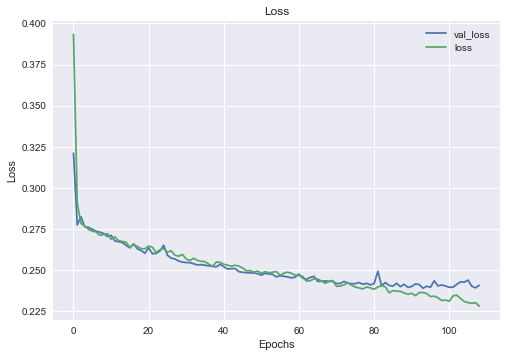

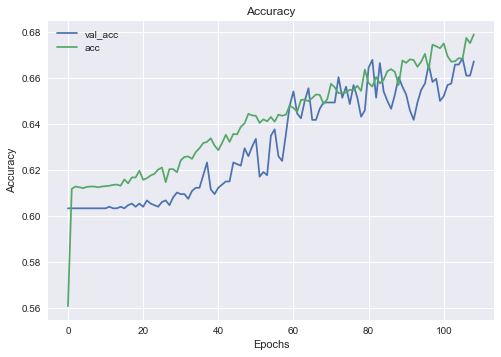

In [210]:
visualize_training_results(history_2)

In [211]:
# Find train and test accuracy
loss, accuracy = lstm_mod2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7100
Testing Accuracy:  0.6756


### Model 3: LSTM Layer Stacking

In [212]:
lstm_mod3 = Sequential()
lstm_mod3.add(embedding_layer)
lstm_mod3.add(Dropout(0.3))
lstm_mod3.add(LSTM(80, 
               dropout = 0.3, 
               recurrent_dropout = 0.5,
               return_sequences = True))
lstm_mod3.add(LSTM(20, 
               dropout = 0.3, 
               recurrent_dropout = 0.5))

lstm_mod3.add(Dense(3, activation='softmax'))
lstm_mod3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_mod3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 24, 50)            507400    
_________________________________________________________________
dropout_11 (Dropout)         (None, 24, 50)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 24, 80)            41920     
_________________________________________________________________
lstm_18 (LSTM)               (None, 20)                8080      
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 63        
Total params: 557,463
Trainable params: 50,063
Non-trainable params: 507,400
_________________________________________________________________


In [213]:
# Import EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=15), 
                  ModelCheckpoint(filepath='best_model_lstm.h5', monitor='val_loss', save_best_only=True)]

In [214]:
history_3 = lstm_mod3.fit(X_train, y_train,
                    validation_split = 0.2,
                    callbacks=early_stopping, 
                    class_weight=class_weights,
                    epochs=200, batch_size=500)

Train on 5818 samples, validate on 1455 samples
Epoch 1/200
5818/5818 [==============================] - 8s 1ms/step - loss: 0.3893 - acc: 0.5657 - val_loss: 0.3000 - val_acc: 0.6034
Epoch 2/200
5818/5818 [==============================] - 3s 554us/step - loss: 0.2923 - acc: 0.6126 - val_loss: 0.2806 - val_acc: 0.6034
Epoch 3/200
5818/5818 [==============================] - 3s 565us/step - loss: 0.2792 - acc: 0.6124 - val_loss: 0.2781 - val_acc: 0.6034
Epoch 4/200
5818/5818 [==============================] - 3s 572us/step - loss: 0.2772 - acc: 0.6126 - val_loss: 0.2778 - val_acc: 0.6034
Epoch 5/200
5818/5818 [==============================] - 4s 610us/step - loss: 0.2760 - acc: 0.6126 - val_loss: 0.2771 - val_acc: 0.6034
Epoch 6/200
5818/5818 [==============================] - 3s 570us/step - loss: 0.2760 - acc: 0.6126 - val_loss: 0.2763 - val_acc: 0.6034
Epoch 7/200
5818/5818 [==============================] - 3s 556us/step - loss: 0.2759 - acc: 0.6126 - val_loss: 0.2752 - val_acc: 0.

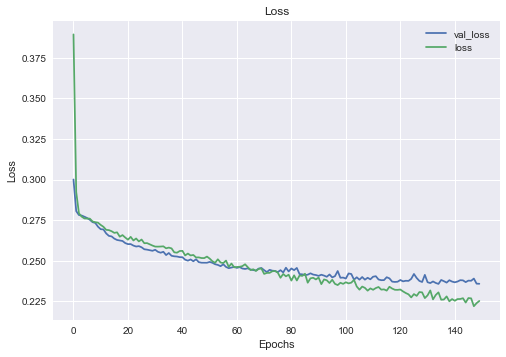

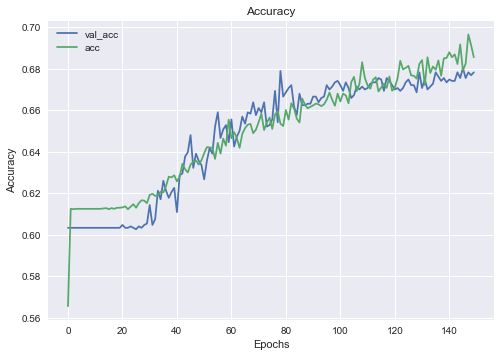

In [215]:
visualize_training_results(history_3)

In [216]:
# Find train and test accuracy
loss, accuracy = lstm_mod3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7210
Testing Accuracy:  0.6905


In [217]:
y_pred = lstm_mod3.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [218]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [219]:
Y_test = np.argmax(y_test, axis=1)
Y_test

array([1, 1, 1, ..., 2, 2, 2])

#### Plot confusion matrix

In [163]:
class_names = np.array(['Negative', 'Positive', 'Neutral'])

In [220]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    plt.grid(False)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[   0   97   16]
 [   0 1046   56]
 [   0  394  210]]
Normalized confusion matrix
[[0.   0.86 0.14]
 [0.   0.95 0.05]
 [0.   0.65 0.35]]


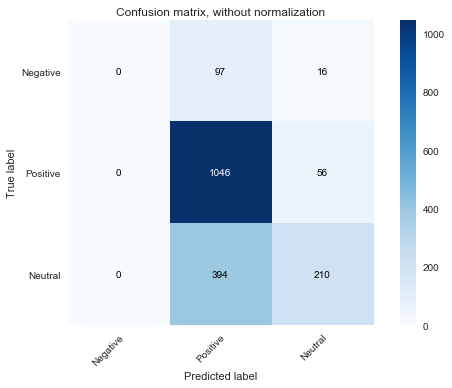

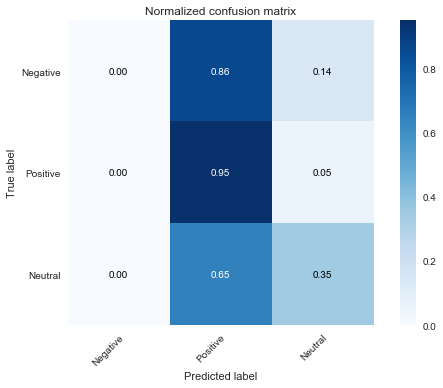

In [221]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Model 4: GRU Layer Stacking

In [225]:
# GRU Model 2: reduce number of epochs
model_4 = Sequential()
model_4.add(embedding_layer)
# model_4.add(Dropout(0.3))
model_4.add(GRU(64, 
               dropout = 0.3, 
               recurrent_dropout = 0.5,
                 return_sequences = True))
model_4.add(GRU(32,
                dropout = 0.3,
                recurrent_dropout = 0.5))
model_4.add(Dense(3, activation='softmax'))
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 24, 50)            507400    
_________________________________________________________________
gru_11 (GRU)                 (None, 24, 64)            22080     
_________________________________________________________________
gru_12 (GRU)                 (None, 32)                9312      
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 99        
Total params: 538,891
Trainable params: 31,491
Non-trainable params: 507,400
_________________________________________________________________


In [226]:
# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=15), 
                  ModelCheckpoint(filepath='best_model_gru.h5', monitor='val_loss', save_best_only=True)]

In [227]:
history_4 = model_4.fit(X_train, y_train,
                    validation_split = 0.2,
                    callbacks=early_stopping, 
                    class_weight=class_weights,
                    epochs=200, batch_size=600)

Train on 5818 samples, validate on 1455 samples
Epoch 1/200
5818/5818 [==============================] - 6s 1ms/step - loss: 0.4337 - acc: 0.5002 - val_loss: 0.2942 - val_acc: 0.6034
Epoch 2/200
5818/5818 [==============================] - 3s 431us/step - loss: 0.3072 - acc: 0.6119 - val_loss: 0.2933 - val_acc: 0.6034
Epoch 3/200
5818/5818 [==============================] - 2s 386us/step - loss: 0.2862 - acc: 0.6128 - val_loss: 0.2801 - val_acc: 0.6034
Epoch 4/200
5818/5818 [==============================] - 2s 395us/step - loss: 0.2826 - acc: 0.6129 - val_loss: 0.2811 - val_acc: 0.6034
Epoch 5/200
5818/5818 [==============================] - 2s 370us/step - loss: 0.2792 - acc: 0.6126 - val_loss: 0.2809 - val_acc: 0.6034
Epoch 6/200
5818/5818 [==============================] - 3s 458us/step - loss: 0.2788 - acc: 0.6124 - val_loss: 0.2783 - val_acc: 0.6034
Epoch 7/200
5818/5818 [==============================] - 2s 391us/step - loss: 0.2769 - acc: 0.6126 - val_loss: 0.2774 - val_acc: 0.

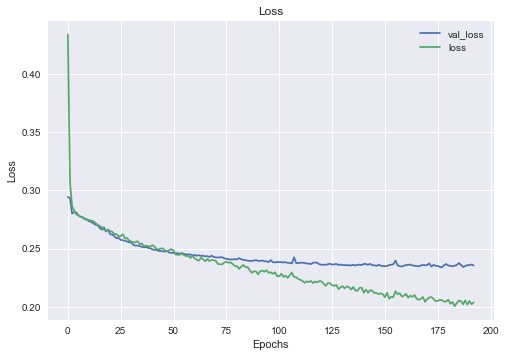

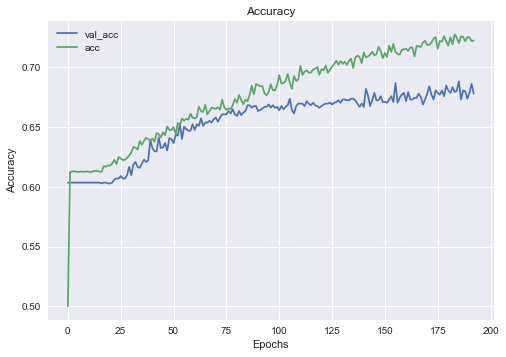

In [228]:
visualize_training_results(history_4)

In [229]:
# Find train and test accuracy
loss, accuracy = model_4.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_4.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7459
Testing Accuracy:  0.6954


### Testing other classification models

Since our data contains tweets and not just words, we’ll have to figure out a way to use the word vectors from GloVe model to create vector representation for an entire tweet. There is a simple solution to this problem, we can simply take mean of all the word vectors present in the tweet. The length of the resultant vector will be the same, i.e. 50. We will repeat the same process for all the tweets in our data and obtain their vectors. Now we have 200 word2vec features for our data.

We will use the below function to create a vector for each tweet by taking the average of the vectors of the words present in the tweet.

In [138]:
class GloVeVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(embeddings_index))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

rf =  Pipeline([('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([('Support Vector Machine', SVC())])
lr = Pipeline([('Logistic Regression', LogisticRegression())])

In [81]:
models = [('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Logistic Regression', lr)]

In [85]:
# ⏰ This cell may take several minutes to run
scores = [(name, cross_val_score(model, padded_data, target, cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [86]:
scores

[('Random Forest', 0.62384513858337),
 ('Support Vector Machine', 0.605917289925209),
 ('Logistic Regression', 0.6055873295204576)]

In [91]:
rf =  Pipeline([('Word2Vec Vectorizer', GloVeVectorizer(embeddings_index)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([('Word2Vec Vectorizer', GloVeVectorizer(embeddings_index)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([('Word2Vec Vectorizer', GloVeVectorizer(embeddings_index)),
              ('Logistic Regression', LogisticRegression())])

In [92]:
models = [('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Logistic Regression', lr)]

In [93]:
# ⏰ This cell may take several minutes to run
scores = [(name, cross_val_score(model, padded_data, target, cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [94]:
scores

[('Random Forest', 0.6097668279806423),
 ('Support Vector Machine', 0.6097668279806423),
 ('Logistic Regression', 0.6097668279806423)]

### Make predictions

In [185]:
label_names

{0: 'Negative emotion', 1: 'Neutral emotion', 2: 'Positive emotion'}

In [187]:
new_tweet = ['Your service is good']
seq = t.texts_to_sequences(new_tweet)
padded = pad_sequences(seq, maxlen=max_tweet_len)
pred = lstm_mod3.predict(padded)
print(pred, "[", np.argmax(pred), "]", label[np.argmax(pred)])

[[0.04 0.47 0.49]] [ 2 ] Positive emotion


In [144]:
new_tweet = ['I love iphone']
seq = t.texts_to_sequences(new_tweet)
padded = pad_sequences(seq, maxlen=max_tweet_len)
pred = lstm_mod3.predict(padded)
print(pred, "[", np.argmax(pred), "]", label[np.argmax(pred)])

[[0.06434713 0.36554193 0.5701109 ]] [ 2 ] Positive emotion


### Summary

#### General Architecture
The inputs for each of the following models are our training data which consists of 7,273 with 20% withheld for validation. Each one of these observations contains 50 “features” which correspond to each word in the tweet. Any 0’s indicate the absence of a word.

Each model ends with a dense layer with 3 nodes, because we have 3 possible labels: positive, neutral, or negative. Because we one-hot encoded our labels, we use softmax for this multiclass classification problem to get a probability for each class. Additionally, we use accuracy as our metric, because this is a classification problem. When we use the predict method from Keras, we get a 3 element row vector for each input. Each element corresponds to a probability of one of the 3 labels. Therefore, the label with the highest probability is the predicted outcome.
We compile each model with adam and categorical crossentropy.

#### Incorporating the GloVe 
GloVe is defined to be an “unsupervised learning algorithm for obtaining vector representations for words”. Pre-trained word vectors data was downloaded from the Standford University website. The models specifically use the 50 -dimensional embeddings of 1.2M words from 2B tweets. This is represented in a txt file that was parsed to create an index that maps words to their vector representation. Using GloVe data improved the accuracy of the model about 3-4%.

#### Best model
All models perform quite well, however, Model 3 with two stacked LSTM layers, seems to have the best train/validation accuracy based on the training/validation results plot (history_3). 

All models have some difficulties with predicting negative emotions due to the class imbalance - small amount of negative labels in the original dataset. In order to mitigate the class imbalace, we passed the pass the class_wieght argument to the fit() functions. This improved the results and reduced overfitting.

Other models performance was significatly lower than NN.

In [ ]:
#